# Quantitative Finance Course Exam - Paper Implementation - Felipe Moret

## "Brokers and Informed Traders: dealing with toxic flow and extracting trading signals" (Alvaro Cartea & Leandro Sanchez-Betancourt)

**Model parameters**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import random
import pandas as pd

T = 1.0 # total time
N = 10000 # number of time steps
dt = T / N # time delta
M = 10000 # number of trajectories

kappa_alpha = 5 # Speed of mean reversion of the alpha signal
sigma_alpha = 1 # Volatility of the alpha signal

kappa_U = 15.0 # Speed of mean reversion of the uninformed flow
sigma_U = 100.0 # Volatility of the uninformed flow

sigma_s = 1 # Volatility of the price

kB = 1.2e-3 # Broker's liquidity cost in the lit market
kI = 1e-3 # Informed trader's liquidity cost in the lit market
kU = 1e-3 # Uninformed trader's liquidity cost in the lit market

phiI = 1e-2
phiB = 1e-10 #

varphiI = 1e-2
varphiB = 1e-2

b = 1e-3 # Permanent impact parameter

aB = 1.0
aI = 1.0

# Initial conditions
alpha_0 = 0.0 # Set initial value for alpha
S_0 = 100.0 # Set initial value for price S
Q_I_0 = 0.0 # Initial infromed trader's inventory 
nu_U_0 = 0 # Initial uninformed trader's trading rate

**Generating the necessary stochastic processes**

In [3]:
alpha = np.zeros((M, N))
nu_U = np.zeros((M, N))
S = np.zeros((M, N))

# Generate all Brownian increments directly (independent for each path)
dW_alpha = np.random.randn(M, N) * np.sqrt(dt)
dW_nu_U = np.random.randn(M, N) * np.sqrt(dt)
dW_S = np.random.randn(M, N) * np.sqrt(dt)

# Initial conditions
alpha[:, 0] = alpha_0
nu_U[:, 0] = nu_U_0  # if you use any initial value
S[:, 0] = S_0

# Simulate paths
for t in range(1, N):
    alpha[:, t] = alpha[:, t-1] * (1 - kappa_alpha * dt) + sigma_alpha * dW_alpha[:, t]
    nu_U[:, t] = nu_U[:, t-1] * (1 - kappa_U * dt) + sigma_U * dW_nu_U[:, t]
    S[:, t] = S[:, t-1] + alpha[:, t-1] * dt + sigma_s * dW_S[:, t]

**Plotting Stochatic Processes Samples**

In [5]:
i = 0 #sample index

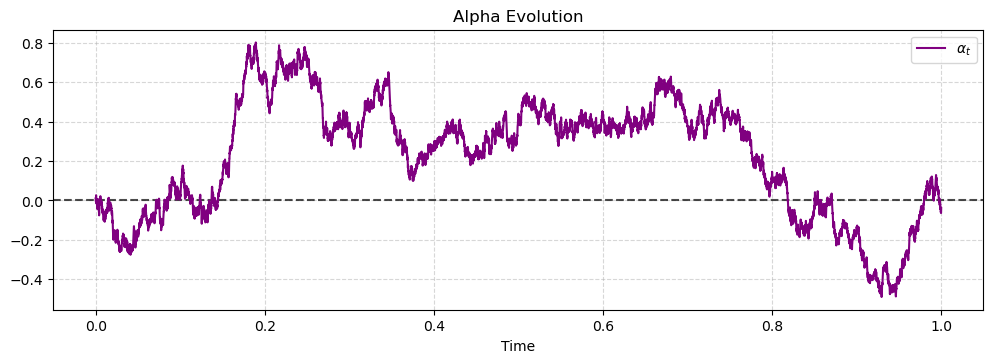

In [6]:
time_grid = np.linspace(0, T, N)
# Plot price S_t
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.axhline(alpha[i,0], color = 'black', linestyle = '--', alpha = 0.7)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.plot(time_grid, alpha[i,:], label = r'$\alpha_{{t}}$', color = 'purple')
plt.title('Alpha Evolution')
plt.xlabel('Time')
plt.legend()
plt.show()

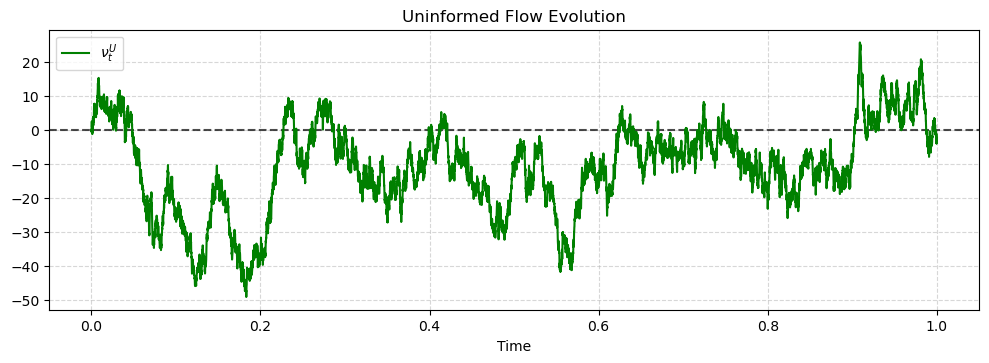

In [7]:
# Plot price S_t
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.axhline(alpha[i,0], color = 'black', linestyle = '--', alpha = 0.7)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.plot(time_grid, nu_U[i,:], label = r'$\nu^{U}_{{t}}$', color = 'green')
plt.title('Uninformed Flow Evolution')
plt.xlabel('Time')
plt.legend()
plt.show()

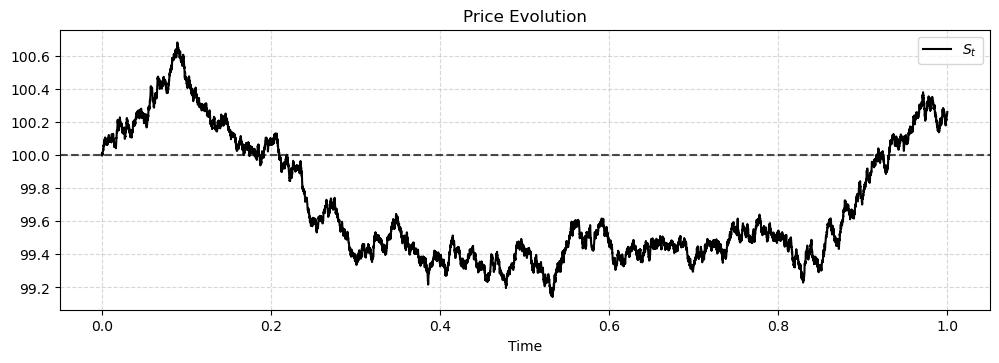

In [8]:
# Plot price S_t
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.axhline(S[i,0], color = 'black', linestyle = '--', alpha = 0.7)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.plot(time_grid, S[i,:], label= r'$S_t$', color = 'black')
plt.title('Price Evolution')
plt.xlabel('Time')
plt.legend()
plt.show()

**Verification of OU's mean and variance of $\alpha_{t}$ and $\nu^U_{t}$**

*Mean:*
$\mathbb{E}[\alpha_t] = \alpha_0 e^{-\kappa_{\alpha} t}$ <br>
*Variance:*
$\text{Var}(\alpha_t) = \frac{\sigma_{\alpha}^2}{2\kappa_{\alpha}} \left(1 - e^{-2\kappa_{\alpha} t}\right)$

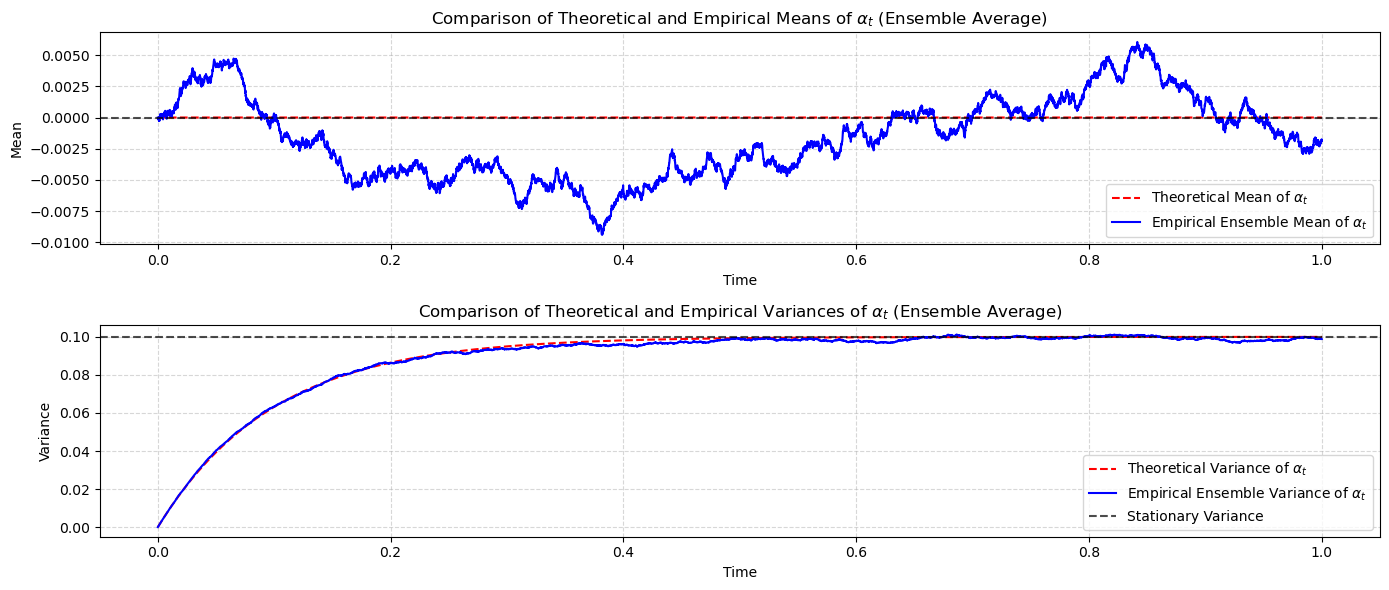

In [11]:
# THEORETICAL CALCULATIONS
expected_alpha_theoretical = np.zeros(N)  # Theoretical mean = 0
var_alpha_theoretical = (sigma_alpha**2) / (2 * kappa_alpha) * (1 - np.exp(-2 * kappa_alpha * time_grid))
var_stationary = (sigma_alpha**2) / (2 * kappa_alpha)

# EMPIRICAL ENSEMBLE CALCULATIONS
ensemble_mean_alpha = np.mean(alpha, axis = 0)  # Média entre trajetórias em cada tempo
ensemble_var_alpha = np.var(alpha, axis = 0)    # Variância entre trajetórias em cada tempo

# PLOTS

plt.figure(figsize=(14, 6))

# Plotting means
plt.subplot(2, 1, 1)
plt.plot(time_grid, expected_alpha_theoretical, label='Theoretical Mean of $\\alpha_t$', color='red', linestyle='dashed')
plt.plot(time_grid, ensemble_mean_alpha, label='Empirical Ensemble Mean of $\\alpha_t$', color='blue')
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.title('Comparison of Theoretical and Empirical Means of $\\alpha_t$ (Ensemble Average)')
plt.xlabel('Time')
plt.ylabel('Mean')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Plotting variances
plt.subplot(2, 1, 2)
plt.plot(time_grid, var_alpha_theoretical, label='Theoretical Variance of $\\alpha_t$', color='red', linestyle='dashed')
plt.plot(time_grid, ensemble_var_alpha, label='Empirical Ensemble Variance of $\\alpha_t$', color='blue')
plt.axhline(var_stationary, color='black', linestyle='--', alpha=0.7, label='Stationary Variance')
plt.title('Comparison of Theoretical and Empirical Variances of $\\alpha_t$ (Ensemble Average)')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

**Mean:**
$\mathbb{E}[\nu^U_t] = \nu^U_0 e^{-\kappa_{U} t}$ <br>
**Variance:**
$\text{Var}(\nu^U_t) = \frac{\sigma_{U}^2}{2\kappa_{U}} \left(1 - e^{-2\kappa_{U} t}\right)$

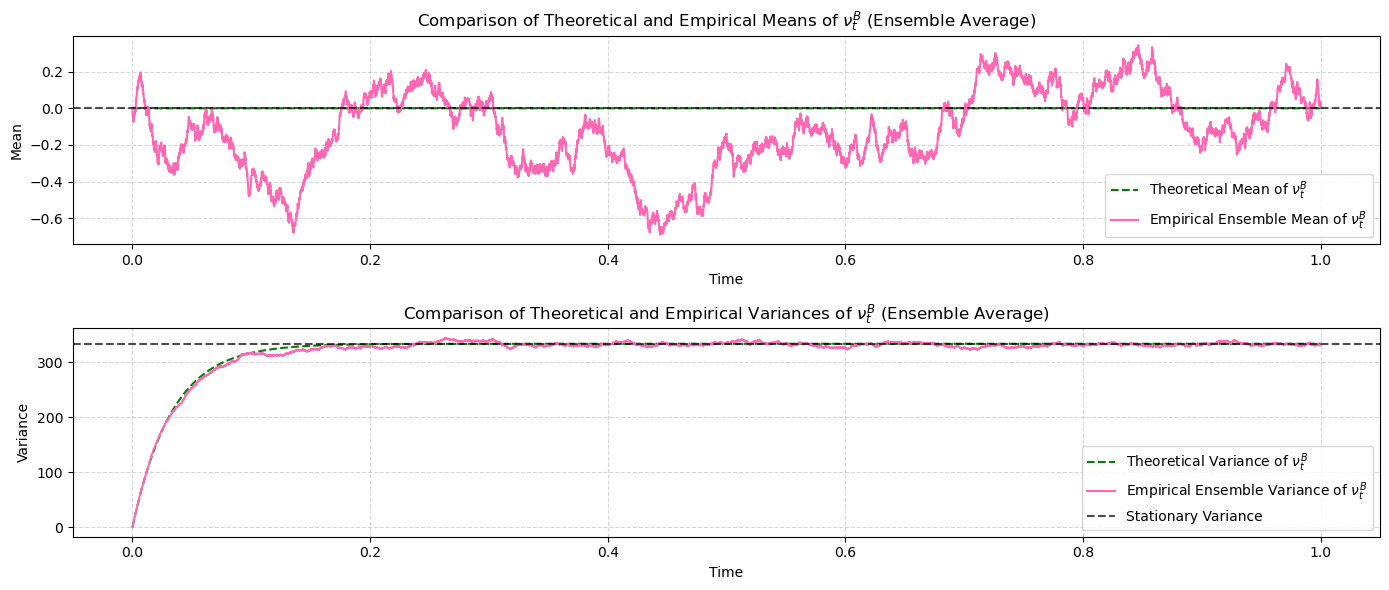

In [13]:
expected_nu_B_theoretical = np.zeros(N)
var_nu_B_theoretical = (sigma_U**2) / (2 * kappa_U) * (1 - np.exp(-2 * kappa_U * time_grid))
var_stationary_nu_B = (sigma_U**2) / (2 * kappa_U)

ensemble_mean_nu_B = np.mean(nu_U, axis=0)
ensemble_var_nu_B = np.var(nu_U, axis=0)

# --- PLOTS ---

plt.figure(figsize=(14, 6))

# --- MEAN ---
plt.subplot(2, 1, 1)
plt.plot(time_grid, expected_nu_B_theoretical, label='Theoretical Mean of $\\nu^B_t$', color='green', linestyle='dashed')
plt.plot(time_grid, ensemble_mean_nu_B, label='Empirical Ensemble Mean of $\\nu^B_t$', color='hotpink')
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.title('Comparison of Theoretical and Empirical Means of $\\nu^B_t$ (Ensemble Average)')
plt.xlabel('Time')
plt.ylabel('Mean')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# --- VARIANCE ---
plt.subplot(2, 1, 2)
plt.plot(time_grid, var_nu_B_theoretical, label='Theoretical Variance of $\\nu^B_t$', color='green', linestyle='dashed')
plt.plot(time_grid, ensemble_var_nu_B, label='Empirical Ensemble Variance of $\\nu^B_t$', color='hotpink')
plt.axhline(var_stationary_nu_B, color='black', linestyle='--', alpha=0.7, label='Stationary Variance')
plt.title('Comparison of Theoretical and Empirical Variances of $\\nu^B_t$ (Ensemble Average)')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()



# Informed Trader's Problem

In [15]:
from numba import njit, prange

# CONSTANTS FOR g0(t)'s and g1(t)'s evaluation
Phi_I = (1/2) * varphiI * ((sigma_s)**2) + phiI
gamma1 = np.sqrt(Phi_I / kI)
zeta1 = (aI + np.sqrt(kI * Phi_I)) / (aI - np.sqrt(kI * Phi_I))

def g(t):
    exp_gamma1 = np.exp(gamma1 * (T - t))
    exp_neg_gamma1 = np.exp(-gamma1 * (T - t))
    exp_neg_kappa_alpha = np.exp(-kappa_alpha * (T - t))
    
    denominator = exp_neg_gamma1 - zeta1 * exp_gamma1
    term1 = zeta1 * (exp_neg_kappa_alpha - exp_gamma1) / (kappa_alpha + gamma1)
    term2 = (exp_neg_kappa_alpha - exp_neg_gamma1) / (kappa_alpha - gamma1)
    
    return (1 / denominator) * (term1 - term2)

def g0(t):
    return g(t) / (2 * kI)

def g1(t):
    num = zeta1 * np.exp(gamma1 * (T - t)) + np.exp(-gamma1 * (T - t))
    den = zeta1 * np.exp(gamma1 * (T - t)) - np.exp(-gamma1 * (T - t))
    return gamma1 * (num / den)

@njit(parallel=True)
def simulate_all_IT(alpha, Q_I_0, g0_vec, g1_vec, dt, M, N):
    Q_I = np.zeros((M, N))
    Q_I_2 = np.zeros((M, N))
    nu_I = np.zeros((M, N))
    
    for m in prange(M):
        Q_I[m, 0] = Q_I_0
        Q_I_2[m, 0] = Q_I_0

        for t in range(1, N):
            g0_t = g0_vec[t]
            g1_t = g1_vec[t]

            # Implicit method
            denom = 1.0 + g1_t * dt
            num = Q_I[m, t-1] + g0_t * alpha[m, t] * dt
            Q_I[m, t] = num / denom
            nu_I[m, t] = g0_t * alpha[m, t] - g1_t * Q_I[m, t]

            # Explicit method
            nu_I[m, t] = g0_t * alpha[m, t] - g1_t * Q_I_2[m, t-1]
            Q_I_2[m, t] = Q_I_2[m, t-1] + nu_I[m, t] * dt

    return Q_I, Q_I_2, nu_I

g0_vec = np.array([g0(t) for t in time_grid])
g1_vec = np.array([g1(t) for t in time_grid])

Q_I, Q_I_2, nu_I = simulate_all_IT(alpha, Q_I_0, g0_vec, g1_vec, dt, M, N)

# Plotting Informed Trader's Optimal Trading Rate and Inventory for samples

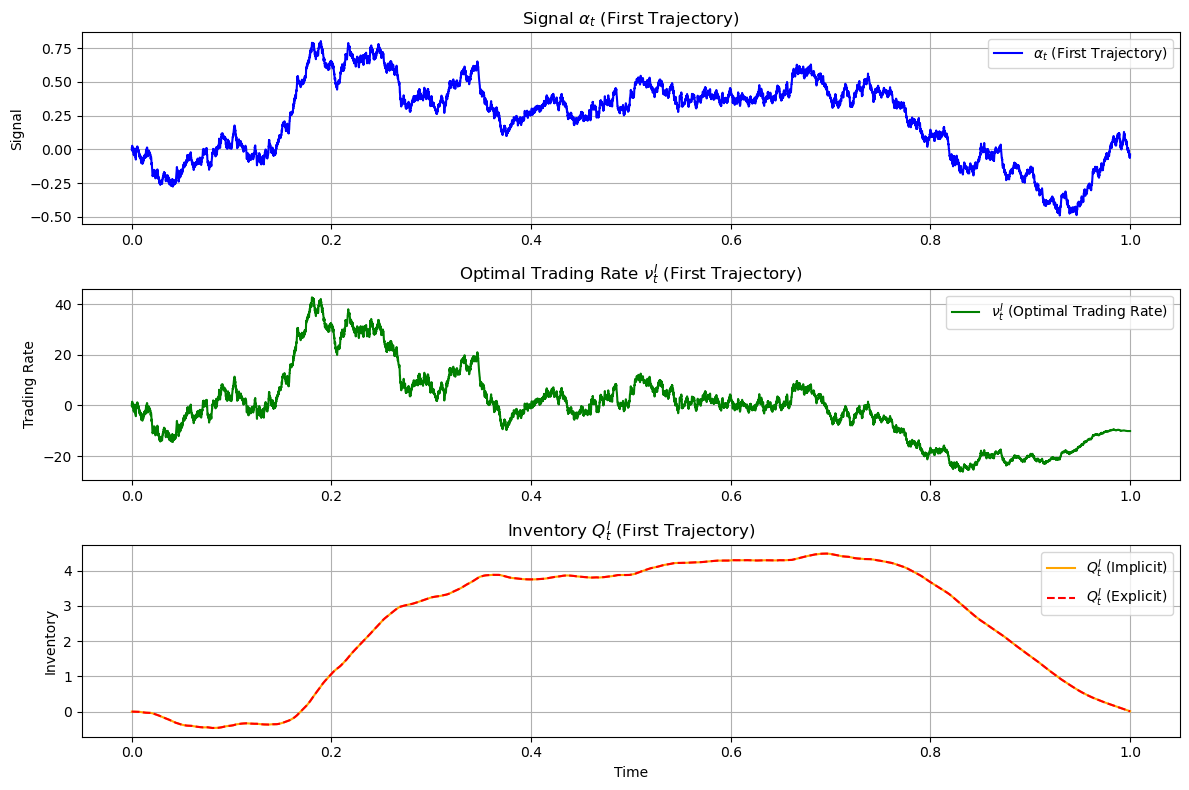

In [17]:
# Example Plot for the i th trajectory

#sample Index
i = 0

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time_grid, alpha[i], label=r'$\alpha_t$ (First Trajectory)', color = 'blue')
plt.ylabel('Signal')
plt.title('Signal $\\alpha_t$ (First Trajectory)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_grid, nu_I[i], label=r'$\nu^I_t$ (Optimal Trading Rate)', color = 'green')
plt.ylabel('Trading Rate')
plt.title('Optimal Trading Rate $\\nu^I_t$ (First Trajectory)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time_grid, Q_I[i], label=r'$Q^I_t$ (Implicit)', color = 'orange')
plt.plot(time_grid, Q_I_2[i], label=r'$Q^I_t$ (Explicit)', color = 'red', linestyle = "--")
plt.xlabel('Time')
plt.ylabel('Inventory')
plt.title('Inventory $Q^I_t$ (First Trajectory)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

**Matrix Differential Riccati Equation - MDRE - $q_2(t), q_4(t), q_6(t), q_9(t), q_{10}(t), q_{12}(t)$**

In [19]:
# === Constant matrix U ===
U = np.array([
    [-2 * varphiB * sigma_alpha**2, 0, 0],
    [0, 1 / kB, 0],
    [0, 0, 0]
])

# === Time-dependent matrices Z(t), Q(t) ===
def Z(t):
    return np.array([
        [-kappa_alpha, 0, 0],
        [-g0(t), b / (2 * kB), g1(t)],
        [g0(t), 0, -g1(t)]
    ])

def Q(t):
    return np.array([
        [kI * g0(t)**2, 0.5, -kI * g0(t) * g1(t)],
        [0.5, (b**2 / (4 * kB)) - phiB, 0],
        [-kI * g0(t) * g1(t), 0, kI * g1(t)**2]
    ])

# === Augmented Riccati system ===
def augmented_riccati(t, Y):
    R = Y[:9].reshape(3, 3)
    T_ = Y[9:].reshape(3, 3)
    Zt = Z(t)
    Qt = Q(t)
    dRdt = Zt @ R + U @ T_
    dTdt = -Qt @ R - Zt.T @ T_
    return np.concatenate([dRdt.flatten(), dTdt.flatten()])

# === Solve augmented system backward ===
R_T = np.eye(3)
S_T = np.zeros((3, 3))
S_T[1, 1] = -aB
Y_T = np.concatenate([R_T.flatten(), S_T.flatten()])

sol = solve_ivp(
    augmented_riccati,
    t_span=(T, 0),
    y0=Y_T,
    t_eval=time_grid[::-1],
    method='RK45',
    rtol=1e-8,
    atol=1e-10
)

R_list = sol.y[:9, :].T.reshape(-1, 3, 3)[::-1]
T_list = sol.y[9:, :].T.reshape(-1, 3, 3)[::-1]
Psol = np.array([T @ np.linalg.inv(R) for T, R in zip(T_list, R_list)])

q2_sol = Psol[:, 0, 0]
q4_sol = Psol[:, 1, 1]
q6_sol = Psol[:, 2, 2]
q9_sol = 2 * Psol[:, 0, 1]
q10_sol = 2 * Psol[:, 0, 2]
q12_sol = 2 * Psol[:, 1, 2]

# === ODE for q11, q13, q14 ===
def ode_q11_q13_q14(t, q_vec):
    q11, q13, q14 = q_vec
    q2_t = np.interp(t, time_grid, q2_sol)
    q4_t = np.interp(t, time_grid, q4_sol)
    q9_t = np.interp(t, time_grid, q9_sol)
    q10_t = np.interp(t, time_grid, q10_sol)
    q12_t = np.interp(t, time_grid, q12_sol)
    g0_t = g0(t)
    g1_t = g1(t)

    dq11dt = -kappa_alpha * q11 - kappa_U * q11 - g0_t * q13 + g0_t * q14 \
             - 2 * varphiB * sigma_alpha**2 * q11 * q2_t - q9_t + (q13 * q9_t) / (2 * kB)

    dq13dt = -kappa_U * q13 + (b * q13) / (2 * kB) - 2 * q4_t + (q13 * q4_t) / kB \
             - varphiB * sigma_alpha**2 * q11 * q9_t

    dq14dt = -varphiB * sigma_alpha**2 * q10_t * q11 - q12_t + g1_t * q13 \
             + (q12_t * q13) / (2 * kB) - kappa_U * q14 - g1_t * q14

    return [-dq11dt, -dq13dt, -dq14dt]

# === Solve ODE backward for q11, q13, q14 ===
sol_q_vect = solve_ivp(
    ode_q11_q13_q14,
    t_span=(T, 0),
    y0=[0, 0, 0],
    t_eval=time_grid[::-1],
    method='RK45',
    rtol=1e-8,
    atol=1e-10
)

q11_sol = sol_q_vect.y[0, ::-1]
q13_sol = sol_q_vect.y[1, ::-1]
q14_sol = sol_q_vect.y[2, ::-1]
tau4_sol = q13_sol / (2 * kB)

# === ODE for q8(t) ===
# def ode_q8(t, q8):
#     q11_t = np.interp(t, time_grid, q11_sol)
#     q13_t = np.interp(t, time_grid, q13_sol)
#     source_term = kappa_U - 0.5 * varphiB * (sigma_alpha * q11_t)**2 - q13_t + (q13_t**2) / (4 * kB)
#     dq8dt = 2 * kappa_U * q8 - source_term
#     return -dq8dt

# sol_q8 = solve_ivp(
#     ode_q8,
#     t_span=(T, 0),
#     y0=[0.0],
#     t_eval=time_grid[::-1],
#     method='RK45',
#     rtol=1e-8,
#     atol=1e-10
# )

# q8_sol = sol_q8.y[0, ::-1]

# === ODE for q8(t) ===
integrand = (
    kappa_U
    - 0.5 * varphiB * sigma_alpha**2 * q11_sol**2
    - q13_sol
    + (q13_sol**2) / (4 * kB)
)

# Inicializa vetor resultado
q8_sol = np.zeros_like(time_grid)

# Loop sobre cada t = time_grid[i]
for i, t in enumerate(time_grid):
    u = time_grid[i:]          # pontos futuros: u ∈ [t, T]
    f = integrand[i:]          # integrando correspondente
    kernel = np.exp(-2 * kappa_U * (u - t))  # núcleo exponencial
    q8_sol[i] = np.trapz(f * kernel, u)  # integração

# # ODE for q0(t)
# def ode_q0(t, q0):
#     q2_t = np.interp(t, time_grid, q2_sol)
#     q8_t = np.interp(t, time_grid, q8_sol)
    
#     dq0dt = (sigma_alpha**2) * q2_t + (sigma_U**2) * q8_t
#     return -dq0dt  # backward in time

# sol_q0 = solve_ivp(
#     ode_q0,
#     [T, 0],
#     [0.0],
#     t_eval = time_grid[::-1],
#     method ='RK45',
#     rtol = 1e-8,
#     atol = 1e-10
# )

# q0_sol = sol_q0.y[0, ::-1]  # reverse time to increasing order

# from scipy.integrate import cumtrapz

# # # Construir o integrando ponto a ponto
# integrand_q0 = (sigma_alpha**2) * q2_sol + (sigma_U**2) * q8_sol_check

# # # Integrar de t até T: inverter grid e integrando
# q0_sol = cumtrapz(integrand_q0[::-1], time_grid[::-1], initial = 0)[::-1]

integrand_q0 = (sigma_alpha**2) * q2_sol + (sigma_U**2) * q8_sol
q0_sol = np.zeros_like(time_grid)

for i, t in enumerate(time_grid):
    u = time_grid[i:]                  # pontos futuros: u ∈ [t, T]
    f = integrand_q0[i:]              # valores correspondentes
    q0_sol[i] = np.trapz(f, u)        # integração simples de t até T

# ODE for q7(t)
def ode_q7(t, q7):
    dq7dt = kappa_U * q7
    return -dq7dt  # backward in time


sol_q7 = solve_ivp(
    ode_q7,
    [T, 0],
    [0.0],
    t_eval = time_grid[::-1],
    method = 'RK45',
    rtol = 1e-8,
    atol = 1e-10
)

q7_sol = sol_q7.y[0, ::-1]  # reverse time to increasing order

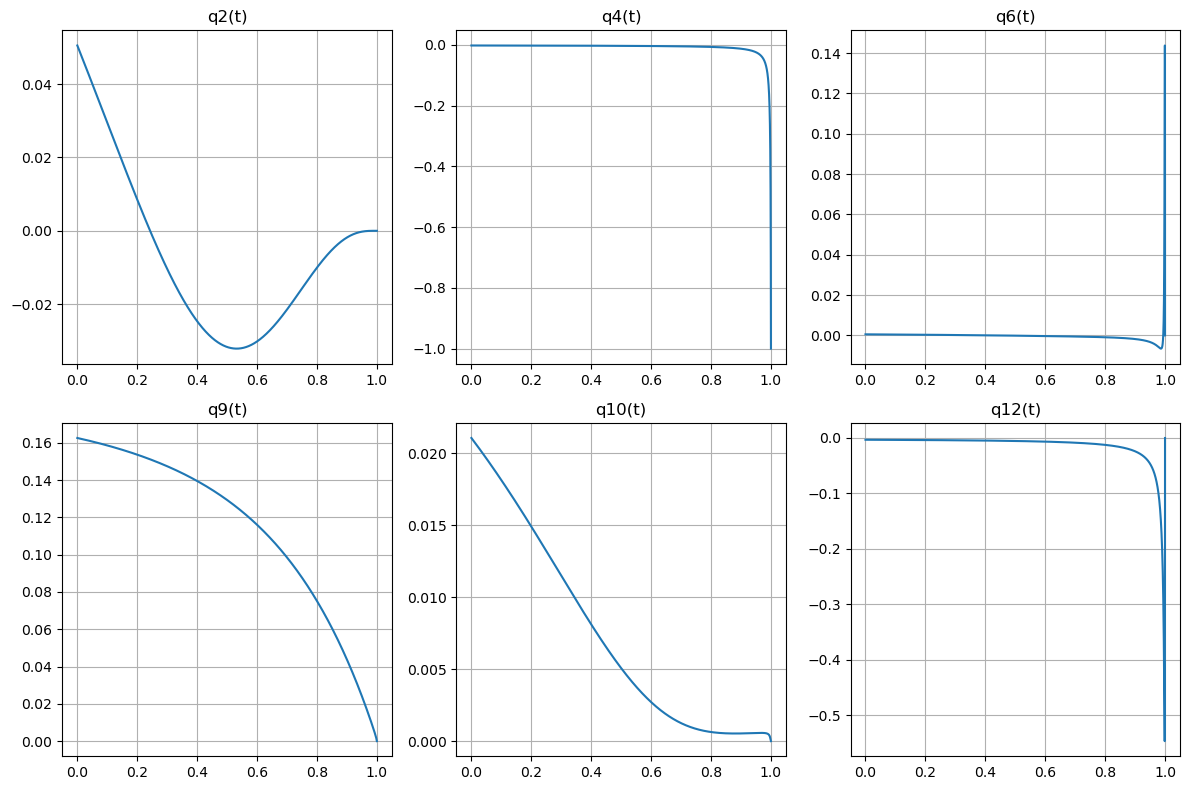

In [21]:
# Create the figure and subplots
fig, axes = plt.subplots(2, 3, figsize = (12, 8))

# First subplot
axes[0, 0].plot(time_grid, q2_sol)
axes[0, 0].set_title('q2(t)')
axes[0, 0].grid(True)

# Second subplot
axes[0, 1].plot(time_grid, q4_sol)
axes[0, 1].set_title('q4(t)')
axes[0, 1].grid(True)

# Third subplot
axes[0, 2].plot(time_grid, q6_sol)
axes[0, 2].set_title('q6(t)')
axes[0, 2].grid(True)

# Fourth subplot
axes[1, 0].plot(time_grid, q9_sol)
axes[1, 0].set_title('q9(t)')
axes[1, 0].grid(True)

# Fifth subplot
axes[1, 1].plot(time_grid, q10_sol)
axes[1, 1].set_title('q10(t)')
axes[1, 1].grid(True)

# Sixth subplot
axes[1, 2].plot(time_grid, q12_sol)
axes[1, 2].set_title('q12(t)')
axes[1, 2].grid(True)

# Adjust layout
plt.tight_layout()


**Matrix Linear Ordinary Differential Equation - MLODE - $q_{11}(t), q_{13}(t), q_{14}(t)$**

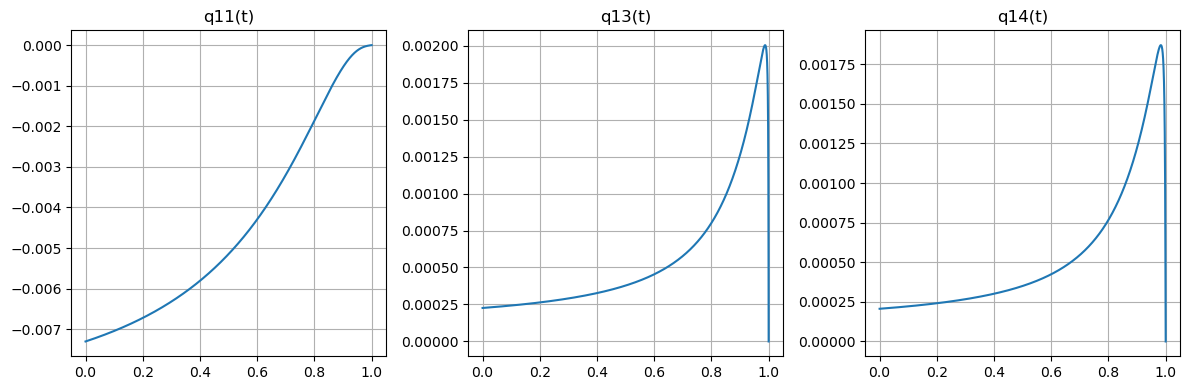

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
axes[0].plot(time_grid, q11_sol)
axes[0].set_title('q11(t)')
axes[0].grid(True)

# Second subplot
axes[1].plot(time_grid, q13_sol)
axes[1].set_title('q13(t)')
axes[1].grid(True)

# Third subplot
axes[2].plot(time_grid, q14_sol)
axes[2].set_title('q14(t)')
axes[2].grid(True)

# Adjust layout
plt.tight_layout()

**Single Linear Ordinary Differential Equaitons - $q_{7}(t)$, $q_{8}(t)$ and $q_{0}(t)$**

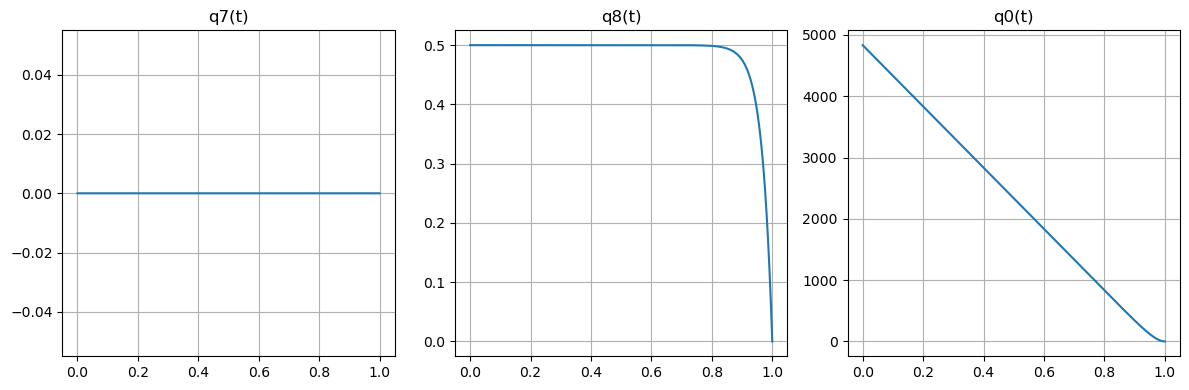

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(time_grid, q7_sol)
axes[0].set_title('q7(t)')
axes[0].grid(True)
# Adjust layout
plt.tight_layout()

# First subplot
axes[1].plot(time_grid, q8_sol)
axes[1].set_title('q8(t)')
axes[1].grid(True)

# Second subplot
axes[2].plot(time_grid, q0_sol)
axes[2].set_title('q0(t)')
axes[2].grid(True)

# Adjust layout
plt.tight_layout()

**Plotting Brokers' Optimal Trading Rate and Optimal Inventory Samples**

In [40]:
def tau1(t):
    q9_t = np.interp(t, time_grid, q9_sol)
    return q9_t / (2 * kB)

def tau2(t):
    q4_t = np.interp(t, time_grid, q4_sol)
    return - (b + 2 * q4_t) / (2 * kB)

def tau3(t):
    q12_t = np.interp(t, time_grid, q12_sol)
    return - q12_t / (2 * kB)

def tau4(t):
    q13_t = np.interp(t, time_grid, q13_sol)
    return q13_t / (2 * kB)

def g3(t):
    g_val = g(t)
    return 2 * kI / g_val  # g3(t) = 2k^I / g(t)

def g2(t): #### BUG HERE
    g1_val = g1(t)
    g0_val = g0(t)
    return g1_val / g0_val  # g2(t) = g1(t) / g0(t)

def tilde_tau1(t):
    q9_t = np.interp(t, time_grid, q9_sol)
    g3_t = g3(t)
    return (q9_t * g3_t) / (2 * kB)

def tilde_tau3(t):
    q9_t = np.interp(t, time_grid, q9_sol)
    q12_t = np.interp(t, time_grid, q12_sol)
    g2_t = g2(t)
    return - (q9_t * g2_t + q12_t) / (2 * kB)

**Plotting $\tau_{1}(t),\tau_{2}(t),\tau_{3}(t),\tau_{4}(t)$**

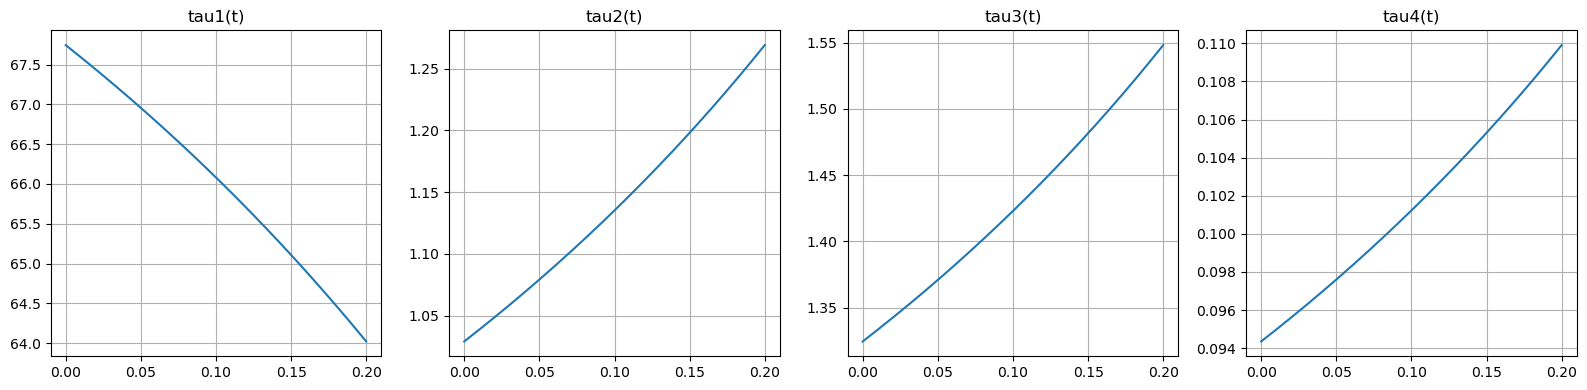

In [43]:
# Evaluate tau functions at the first 2000 points of time_grid
t_vals = time_grid[:2000]

tau1_vals = [tau1(t) for t in t_vals]
tau2_vals = [tau2(t) for t in t_vals]
tau3_vals = [tau3(t) for t in t_vals]
tau4_vals = [tau4(t) for t in t_vals]

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Plot tau1(t)
axes[0].plot(t_vals, tau1_vals)
axes[0].set_title('tau1(t)')
axes[0].grid(True)

# Plot tau2(t)
axes[1].plot(t_vals, tau2_vals)
axes[1].set_title('tau2(t)')
axes[1].grid(True)

# Plot tau3(t)
axes[2].plot(t_vals, tau3_vals)
axes[2].set_title('tau3(t)')
axes[2].grid(True)

# Plot tau4(t)
axes[3].plot(t_vals, tau4_vals)
axes[3].set_title('tau4(t)')
axes[3].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [45]:
@njit(parallel = True)
def simulate_broker_all_with_benchmarks(M, N, dt, time_grid,
                                        alpha, Q_I, nu_I, nu_U,
                                        tau1_vec, tau2_vec, tau3_vec, tau4_vec):
    
    Q_B = np.zeros((M, N))
    Q_B_2 = np.zeros((M, N))
    Q_U = np.zeros((M, N))
    nu_B = np.zeros((M, N))

    # Benchmarks
    Q_B1 = np.zeros((M, N))
    Q_B2 = np.zeros((M, N))
    Q_B3 = np.zeros((M, N))
    nu_B1 = np.zeros((M, N))
    nu_B2 = np.zeros((M, N))
    nu_B3 = np.zeros((M, N))

    epsilon = 1e-10

    # Fill Q_U
    for m in prange(M):
        for n in range(1, N):
            Q_U[m, n] = Q_U[m, n - 1] + nu_U[m, n - 1] * dt

    for m in prange(M):
        for n in range(1, N):
            t = time_grid[n]

            tau1_t = tau1_vec[n]
            tau2_t = tau2_vec[n]
            tau3_t = tau3_vec[n]
            tau4_t = tau4_vec[n]

            alpha_t = alpha[m, n]
            Q_I_t = Q_I[m, n]
            nu_I_t = nu_I[m, n]
            nu_U_t = nu_U[m, n]

            Q_B_prev_imp = Q_B[m, n - 1]
            Q_B_prev_exp = Q_B_2[m, n - 1]

            # Implicit scheme
            denom = 1.0 + tau2_t * dt
            num = Q_B_prev_imp + dt * (
                tau1_t * alpha_t - tau3_t * Q_I_t + (tau4_t - 1.0) * nu_U_t - nu_I_t
            )
            Q_B[m, n] = num / denom

            nu_B[m, n] = (
                tau1_t * alpha_t
                - tau2_t * Q_B[m, n]
                - tau3_t * Q_I_t
                + tau4_t * nu_U_t
            )

            # Explicit scheme
            nu_B_t_exp = (
                tau1_t * alpha_t
                - tau2_t * Q_B_prev_exp
                - tau3_t * Q_I_t
                + tau4_t * nu_U_t
            )
            Q_B_2[m, n] = Q_B_prev_exp + (nu_B_t_exp - nu_U_t - nu_I_t) * dt

            # Benchmark 1
            TWAP_1 = Q_B1[m, n - 1] / max(1.0 - t, epsilon)
            nu_B1[m, n] = nu_I_t - TWAP_1
            Q_B1[m, n] = Q_B1[m, n - 1] + (nu_B1[m, n] - nu_U_t - nu_I_t) * dt

            # Benchmark 2
            TWAP_2 = Q_B2[m, n - 1] / max(1.0 - t, epsilon)
            nu_B2[m, n] = -TWAP_2
            Q_B2[m, n] = Q_B2[m, n - 1] + (nu_B2[m, n] - nu_U_t - nu_I_t) * dt

            # Benchmark 3
            nu_B3[m, n] = nu_I_t + nu_U_t
            Q_B3[m, n] = Q_B3[m, n - 1] + (nu_B3[m, n] - nu_U_t - nu_I_t) * dt

    return Q_B, Q_B_2, Q_U, nu_B, Q_B1, Q_B2, Q_B3, nu_B1, nu_B2, nu_B3

tau1_vec = np.array([tau1(t) for t in time_grid])
tau2_vec = np.array([tau2(t) for t in time_grid])
tau3_vec = np.array([tau3(t) for t in time_grid])
tau4_vec = np.array([tau4(t) for t in time_grid])

Q_B, Q_B_2, Q_U, nu_B, Q_B1, Q_B2, Q_B3, nu_B1, nu_B2, nu_B3 = simulate_broker_all_with_benchmarks(
    M, N, dt, time_grid, alpha, Q_I, nu_I, nu_U,
    tau1_vec, tau2_vec, tau3_vec, tau4_vec)

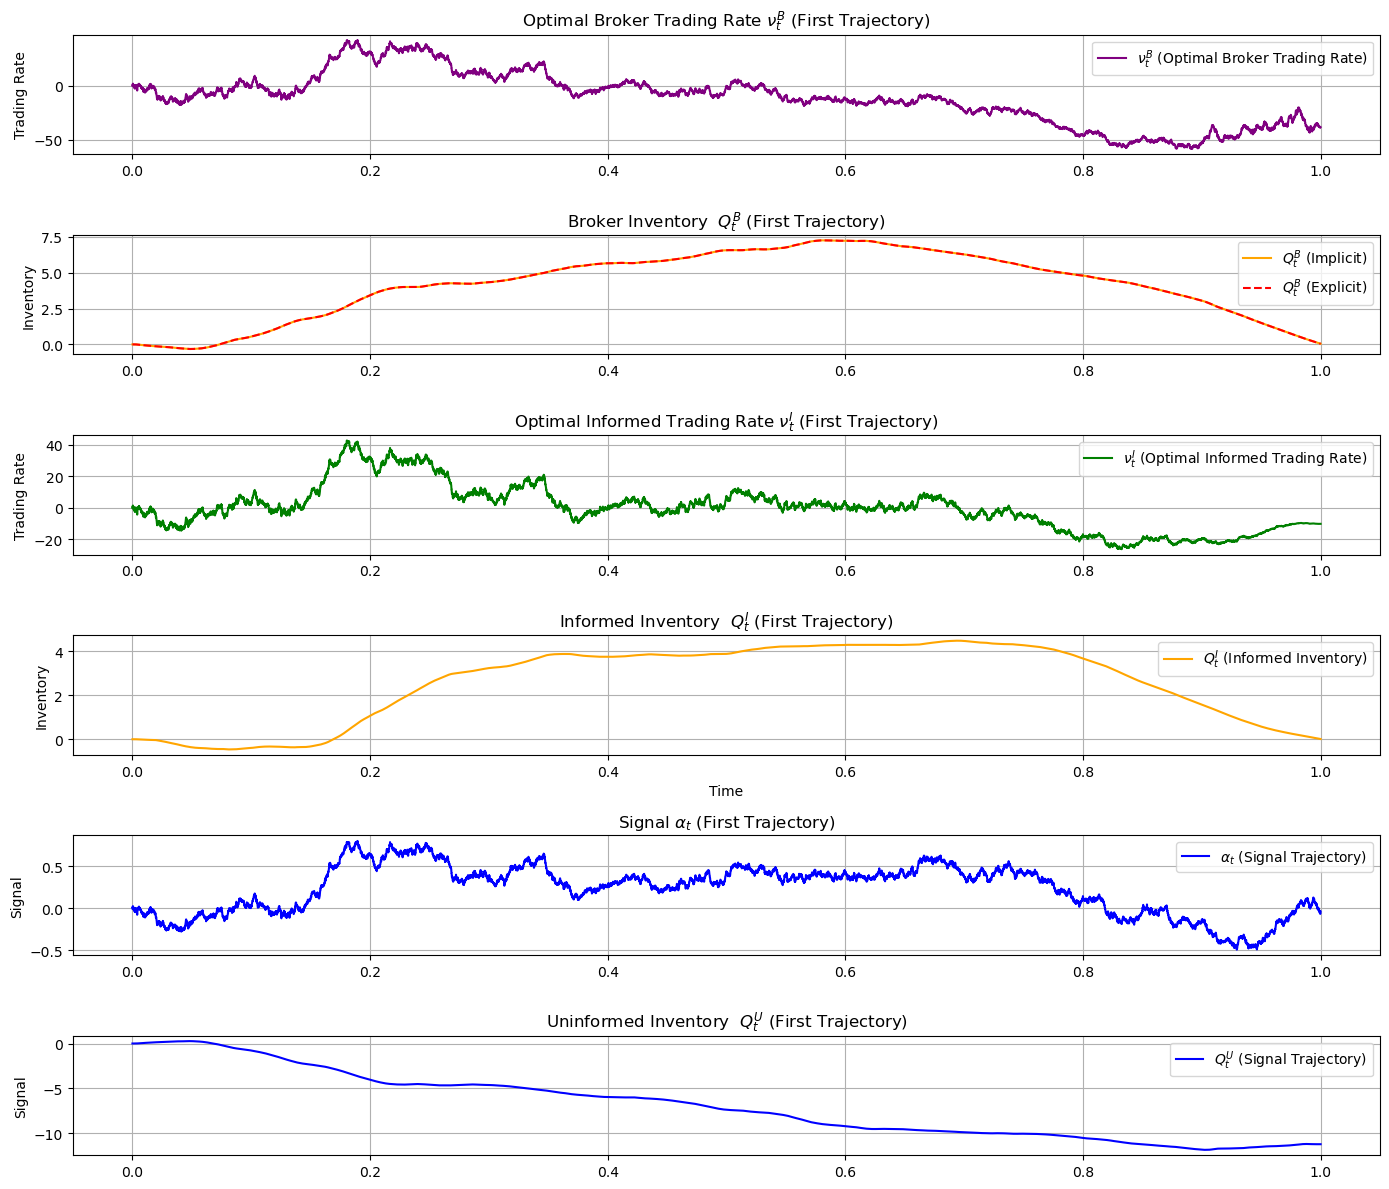

In [46]:
# Example Plot for the i-th trajectory: Broker first

#sample index
i = 0

plt.figure(figsize = (14, 12))

# First subplot: Optimal trading rate of the broker
plt.subplot(6, 1, 1)
plt.plot(time_grid, nu_B[i], label=r'$\nu^B_t$ (Optimal Broker Trading Rate)', color='purple')
plt.ylabel('Trading Rate')
plt.title('Optimal Broker Trading Rate $\\nu^B_t$ (First Trajectory)')
plt.grid(True)
plt.legend()

# Second subplot: Inventory of the broker
plt.subplot(6, 1, 2)
plt.plot(time_grid, Q_B[i], label=r'$Q^B_t$ (Implicit)', color='orange')
plt.plot(time_grid, Q_B_2[i], label=r'$Q^B_t$ (Explicit)', color='red', linestyle = "--")
plt.ylabel('Inventory')
plt.title('Broker Inventory $\\ Q^B_t$ (First Trajectory)')
plt.grid(True)
plt.legend()

# Fourth subplot: Optimal trading rate of the informed
plt.subplot(6, 1, 3)
plt.plot(time_grid, nu_I[i], label=r'$\nu^I_t$ (Optimal Informed Trading Rate)', color='green')
plt.ylabel('Trading Rate')
plt.title('Optimal Informed Trading Rate $\\nu^I_t$ (First Trajectory)')
plt.grid(True)
plt.legend()

# Fifth subplot: Inventory of the informed
plt.subplot(6, 1, 4)
plt.plot(time_grid, Q_I[i], label=r'$Q^I_t$ (Informed Inventory)', color='orange')
plt.xlabel('Time')
plt.ylabel('Inventory')
plt.title('Informed Inventory $\\ Q^I_t$ (First Trajectory)')
plt.grid(True)
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(time_grid, alpha[i], label=r'$\alpha_t$ (Signal Trajectory)', color='blue')
plt.ylabel('Signal')
plt.title('Signal $\\alpha_t$ (First Trajectory)')
plt.grid(True)
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(time_grid, Q_U[i], label = r'$Q^U_t$ (Signal Trajectory)', color='blue')
plt.ylabel('Signal')
plt.title('Uninformed Inventory $\\ Q^U_t$ (First Trajectory)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

**Generating Price Series with Permanent Impact**

In [50]:
S_impacted = S + b * np.cumsum(nu_B * dt, axis = 1)

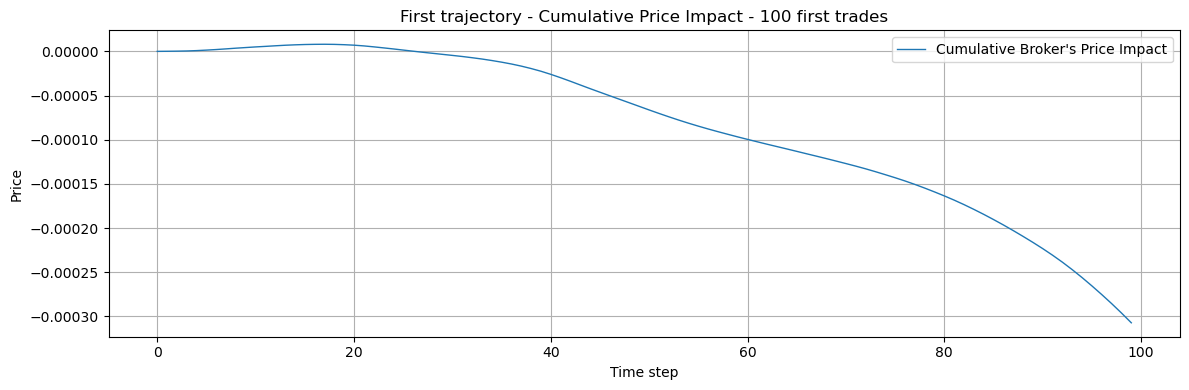

In [51]:
# Plot the first trajectory of cumulated impact
plt.figure(figsize = (12, 4))
plt.plot(np.cumsum(S_impacted[0][:100] - S[0][:100]), label = 'Cumulative Broker\'s Price Impact', linewidth = 1)
plt.title('First trajectory - Cumulative Price Impact - 100 first trades')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**PnL Analysis - Broker**

In [55]:
# Initialize broker cash flow matrices
broker_cash_U = np.zeros((M, N))
broker_cash_I = np.zeros((M, N))
broker_cash_lit = np.zeros((M, N))
X_B = np.zeros((M, N))

broker_cash_lit_1 = np.zeros((M, N))
broker_cash_lit_2 = np.zeros((M, N))
broker_cash_lit_3 = np.zeros((M, N))
X_B1 = np.zeros((M, N))
X_B2 = np.zeros((M, N))
X_B3 = np.zeros((M, N))

# Compute broker cash flows
broker_cash_U = nu_U * (S_impacted + kU * nu_U)
broker_cash_I = nu_I * (S_impacted + kI * nu_I)
broker_cash_lit = -nu_B * (S_impacted + kB * nu_B)
broker_cash_lit_1 = -nu_B1 * (S_impacted + kB * nu_B1)
broker_cash_lit_2 = -nu_B2 * (S_impacted + kB * nu_B2)
broker_cash_lit_3 = -nu_B3 * (S_impacted + kB * nu_B3)

# Compute cumulative cash accounts
broker_cash_U = np.cumsum(broker_cash_U, axis = 1) * dt
broker_cash_I = np.cumsum(broker_cash_I, axis = 1) * dt
broker_cash_lit = np.cumsum(broker_cash_lit, axis = 1) * dt
broker_cash_lit_1 = np.cumsum(broker_cash_lit_1, axis = 1) * dt
broker_cash_lit_2 = np.cumsum(broker_cash_lit_2, axis = 1) * dt
broker_cash_lit_3 = np.cumsum(broker_cash_lit_3, axis = 1) * dt

# Total broker cash accounts
X_B = broker_cash_U + broker_cash_I + broker_cash_lit
X_B1 = broker_cash_U + broker_cash_I + broker_cash_lit_1
X_B2 = broker_cash_U + broker_cash_I + broker_cash_lit_2
X_B3 = broker_cash_U + broker_cash_I + broker_cash_lit_3

# Initialize PnL matrices
PnL_informed = np.zeros((M, N))
PnL_uninformed = np.zeros((M, N))
PnL_lit = np.zeros((M, N))
PnL_B = np.zeros((M, N))

PnL_lit_1 = np.zeros((M, N))
PnL_lit_2 = np.zeros((M, N))
PnL_lit_3 = np.zeros((M, N))
PnL_B1 = np.zeros((M, N))
PnL_B2 = np.zeros((M, N))
PnL_B3 = np.zeros((M, N))

# Compute PnL components
PnL_informed = broker_cash_I - S_impacted * Q_I
PnL_uninformed = broker_cash_U - S_impacted * Q_U

PnL_lit = broker_cash_lit + S_impacted * (Q_B + Q_I + Q_U)
PnL_B = PnL_informed + PnL_uninformed + PnL_lit

PnL_lit_1 = broker_cash_lit_1 + S_impacted * (Q_B1 + Q_I + Q_U)
PnL_lit_2 = broker_cash_lit_2 + S_impacted * (Q_B2 + Q_I + Q_U)
PnL_lit_3 = broker_cash_lit_3 + S_impacted * (Q_B3 + Q_I + Q_U)

PnL_B1 = PnL_informed + PnL_uninformed + PnL_lit_1
PnL_B2 = PnL_informed + PnL_uninformed + PnL_lit_2
PnL_B3 = PnL_informed + PnL_uninformed + PnL_lit_3

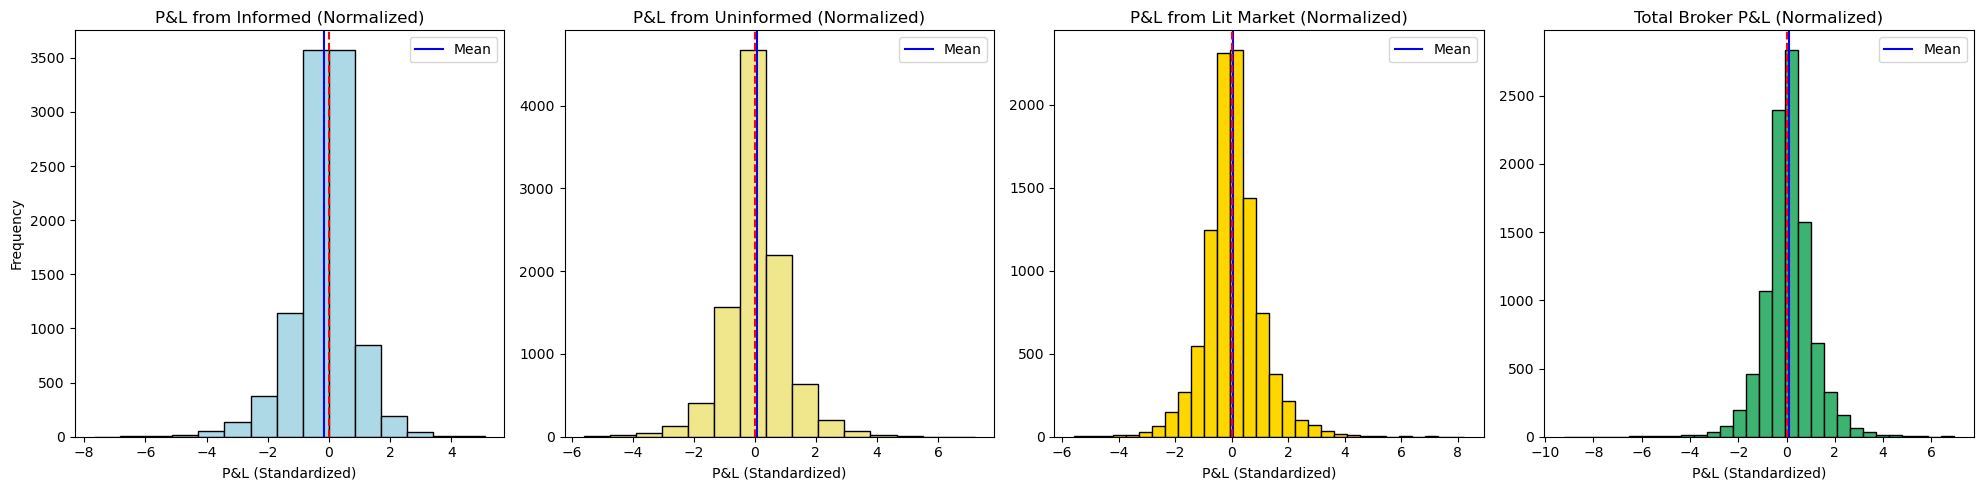

In [56]:
# Normalize PnLs
PnL_informed_normalized = ((PnL_informed[:,-1]) / np.std(PnL_informed[:,-1]))
PnL_uninformed_normalized = (PnL_uninformed[:,-1]) / np.std(PnL_uninformed[:,-1])
PnL_lit_normalized = ((PnL_lit[:,-1]) / np.std(PnL_lit[:,-1]))
PnL_total_normalized = ((PnL_B[:,-1]) / np.std(PnL_B[:,-1]))

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# PnL from informed
axs[0].hist(PnL_informed_normalized, bins = 15, color='lightblue', edgecolor='black')
axs[0].axvline(np.mean(PnL_informed_normalized), color='blue', label='Mean', linestyle='-')
axs[0].axvline(0, color='red', linestyle='--')
axs[0].set_title('P&L from Informed (Normalized)')
axs[0].set_xlabel('P&L (Standardized)')
axs[0].set_ylabel('Frequency')
axs[0].legend()

# PnL from uninformed
axs[1].hist(PnL_uninformed_normalized, bins = 15, color='khaki', edgecolor='black')
axs[1].axvline(np.mean(PnL_uninformed_normalized), color='blue', label = 'Mean', linestyle = '-')
axs[1].axvline(0, color='red', linestyle='--')
axs[1].set_title('P&L from Uninformed (Normalized)')
axs[1].set_xlabel('P&L (Standardized)')
axs[1].legend()

# PnL from lit market (broker trading)
axs[2].hist(PnL_lit_normalized, bins = 30, color='gold', edgecolor='black')
axs[2].axvline(np.mean(PnL_lit_normalized), color='blue', label='Mean', linestyle='-')
axs[2].axvline(0, color='red', linestyle='--')
axs[2].set_title('P&L from Lit Market (Normalized)')
axs[2].set_xlabel('P&L (Standardized)')
axs[2].legend()

# Total PnL
axs[3].hist(PnL_total_normalized, bins = 30, color='mediumseagreen', edgecolor='black')
axs[3].axvline(np.mean(PnL_total_normalized), color='blue', label='Mean', linestyle='-')
axs[3].axvline(0, color='red', linestyle = '--')
axs[3].set_title('Total Broker P&L (Normalized)')
axs[3].set_xlabel('P&L (Standardized)')
axs[3].legend()

plt.tight_layout()
plt.show()

In [57]:
PnL_informed[:,-1].mean()

-0.2976238864891152

In [58]:
PnL_uninformed[:,-1].mean()

0.3020575781347714

In [59]:
PnL_lit[:,-1].mean()

0.19714171707608164

In [110]:
PnL_B[:,-2].mean()

0.20164844104582438

In [111]:
PnL_B1[:,-2].mean()

0.12448138765480567

In [62]:
PnL_B2[:,-2].mean()

-0.09021240768778369

In [63]:
PnL_B3[:,-2].mean()

-0.09101269151763001

**Mean PnL over time - Optimal Strategy and Benchmarks**

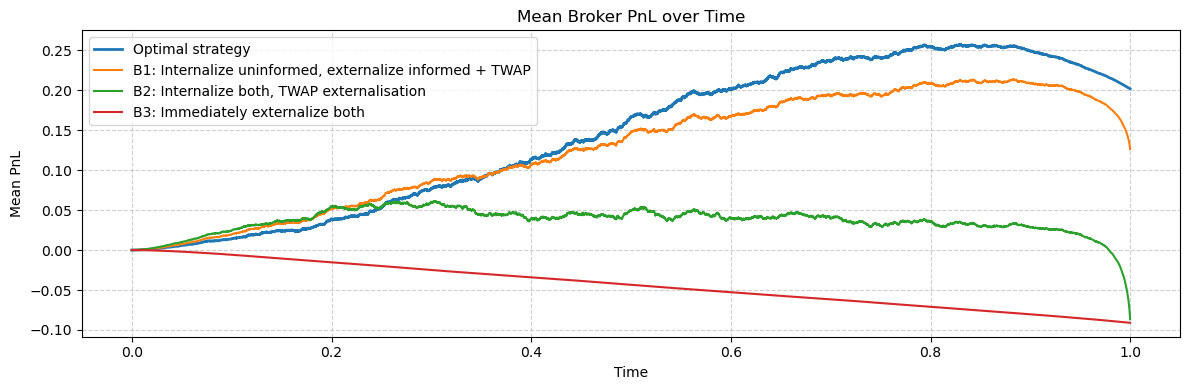

In [74]:
# Plot mean PnLs over time
plt.figure(figsize=(12, 4))

plt.plot(time_grid[:-2], PnL_B[:,:-2].mean(axis = 0), label = "Optimal strategy", linewidth=2)
plt.plot(time_grid[:-2], PnL_B1[:,:-2].mean(axis = 0), label = "B1: Internalize uninformed, externalize informed + TWAP")
plt.plot(time_grid[:-2], PnL_B2[:,:-2].mean(axis = 0), label = "B2: Internalize both, TWAP externalisation")
plt.plot(time_grid[:-2], PnL_B3[:,:-2].mean(axis = 0), label = "B3: Immediately externalize both")

plt.title("Mean Broker PnL over Time")
plt.xlabel("Time")
plt.ylabel("Mean PnL")
plt.legend()
plt.grid(True, linestyle="--", alpha = 0.6)
plt.tight_layout()
plt.show()

**Outperformance of the Optimal Strategy**

In [185]:
def compute_outperformance(
    X_B, Q_B, 
    X_B1, Q_B1, 
    X_B2, Q_B2, 
    X_B3, Q_B3, 
    S_impacted, 
    nu_I, nu_U, nu_B,
    PnL_B,
    PnL_B1,
    PnL_B2,
    PnL_B3,
    dt
):

    M, N = S_impacted.shape

    # denominator
    denom = np.sum(S_impacted[:,:-2] * (np.abs(nu_I[:,:-2]) + np.abs(nu_U[:,:-2]) + np.abs(nu_B[:,:-2])), axis = 1) * dt
    
    # outperformance mean per trajectory
    out_B1_mean = ((PnL_B - PnL_B1) / denom).mean()
    out_B2_mean = ((PnL_B - PnL_B2) / denom).mean()
    out_B3_mean = ((PnL_B - PnL_B3) / denom).mean()

    # outperformance std per trajectory
    out_B1_std = ((PnL_B - PnL_B1) / denom).std()
    out_B2_std = ((PnL_B - PnL_B2) / denom).std()
    out_B3_std = ((PnL_B - PnL_B3) / denom).std()

    data = {
        'mean': [out_B1_mean, out_B2_mean, out_B3_mean],
        'std': [out_B1_std, out_B2_std, out_B3_std]
    }
    
    index = ['B1', 'B2', 'B3']
    return pd.DataFrame(data, index = index)

In [187]:
out_performance_df = compute_outperformance(
    X_B = X_B[:, -1], Q_B = Q_B[:, -1],
    X_B1 = X_B1[:, -1], Q_B1 = Q_B1[:, -1],
    X_B2 = X_B2[:, -1], Q_B2 = Q_B2[:, -1],
    X_B3 = X_B3[:, -1], Q_B3 = Q_B3[:, -1],
    S_impacted = S_impacted,
    nu_I = nu_I, nu_U = nu_U, nu_B = nu_B,
    PnL_B = PnL_B[:,-2], PnL_B1 = PnL_B1[:,-2], PnL_B2 = PnL_B2[:,-2], PnL_B3 = PnL_B3[:,-2], dt = dt
)

In [191]:
out_performance_df*1000000

,mean,std
B1,18.631133,296.645926
B2,69.757681,564.195061
B3,77.105530,590.126348


**IT PNL Mean PNL Analysis**

In [332]:
# Initialize arrays
X_I = np.zeros((M, N))      # cash account of informed trader
PnL_I = np.zeros((M, N))     # total PnL of informed trader

# Compute
for m in range(M):
    dX_I = -nu_I[m, :] * (S_impacted[m, :] + kI * nu_I[m, :]) * dt  # instantaneous cash change
    X_I[m, :] = np.cumsum(dX_I)  # cumulative cash
    PnL_I[m, :] = X_I[m, :] + S_impacted[m, :] * Q_I[m, :]  # cash + mark-to-market value
    
# Compute mean over M trajectories (axis=0)
mean_X_I = np.mean(X_I, axis = 0)
mean_PnL_I = np.mean(PnL_I, axis = 0)

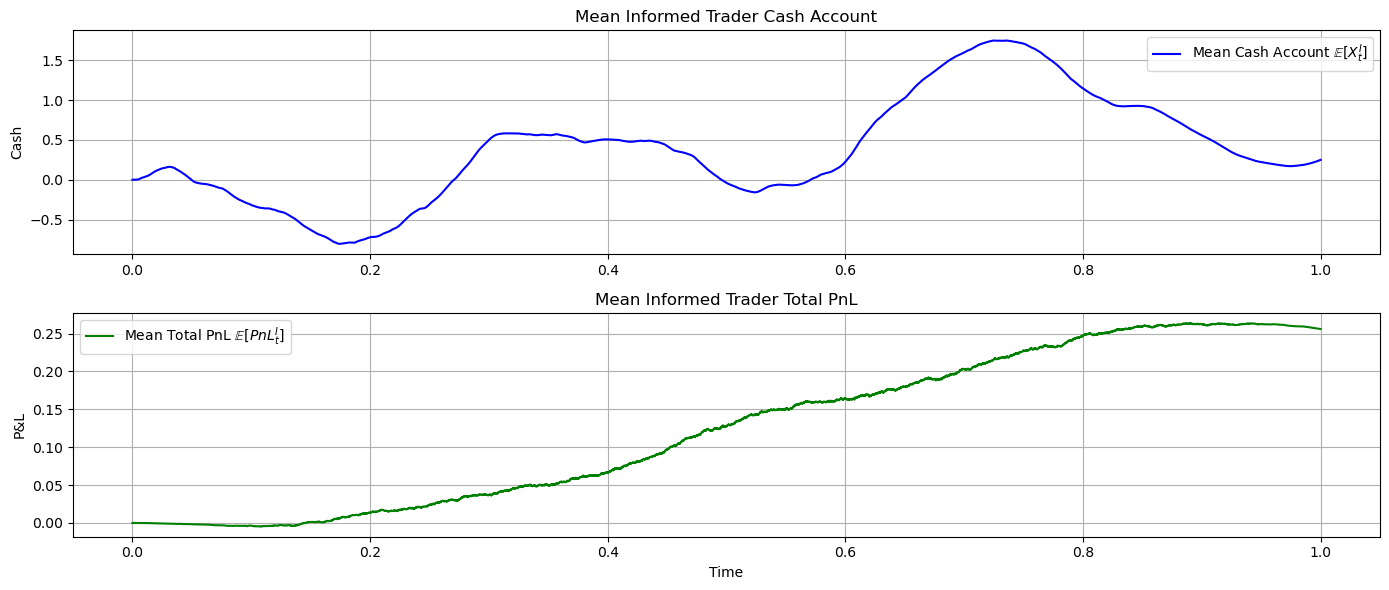

In [333]:
plt.figure(figsize=(14, 6))

# Mean Cash Account
plt.subplot(2, 1, 1)
plt.plot(time_grid, mean_X_I, label='Mean Cash Account $\\mathbb{E}[X^I_t]$', color='blue')
plt.ylabel('Cash')
plt.title('Mean Informed Trader Cash Account')
plt.grid(True)
plt.legend()

# Mean Total P&L
plt.subplot(2, 1, 2)
plt.plot(time_grid, mean_PnL_I, label='Mean Total PnL $\\mathbb{E}[PnL^I_t]$', color='green')
plt.xlabel('Time')
plt.ylabel('P&L')
plt.title('Mean Informed Trader Total PnL')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [337]:
mean_PnL_I[-1]

0.25605263556439695

**NT PNL Mean PNL Analysis**

In [340]:
# Initialize arrays
X_U = np.zeros((M, N)) # cash account of uninformed trader
PnL_U = np.zeros((M, N)) # total PnL of uninformed trader

# Compute
for m in range(M):
    dX_U = -nu_U[m, :] * (S_impacted[m, :] + kU * nu_U[m, :]) * dt  # instantaneous cash change
    X_U[m, :] = np.cumsum(dX_U)  # cumulative cash
    PnL_U[m, :] = X_U[m, :] + S_impacted[m, :] * Q_U[m, :]  # cash + mark-to-market value

# Compute mean over M trajectories (axis=0)
mean_X_U = np.mean(X_U, axis = 0)
mean_PnL_U = np.mean(PnL_U, axis = 0)

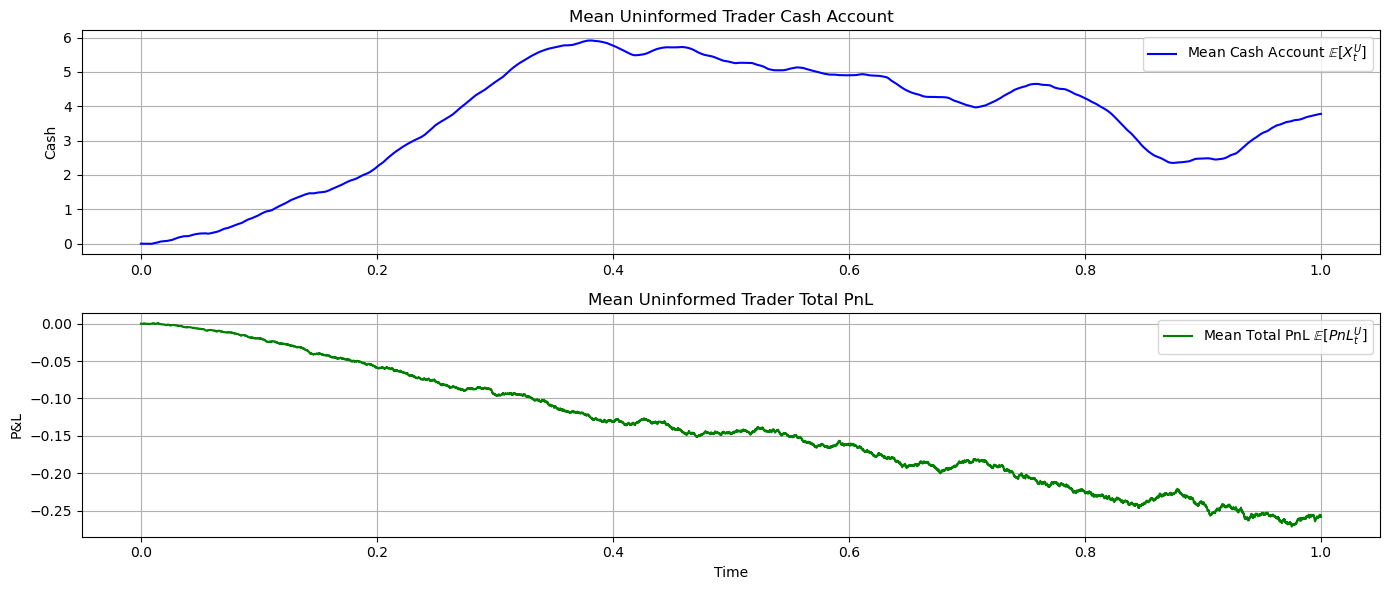

In [341]:
plt.figure(figsize=(14, 6))

# Mean Cash Account of Uninformed
plt.subplot(2, 1, 1)
plt.plot(time_grid, mean_X_U, label='Mean Cash Account $\\mathbb{E}[X^U_t]$', color='blue')
plt.ylabel('Cash')
plt.title('Mean Uninformed Trader Cash Account')
plt.grid(True)
plt.legend()

# Mean Total PnL of Uninformed
plt.subplot(2, 1, 2)
plt.plot(time_grid, mean_PnL_U, label='Mean Total PnL $\\mathbb{E}[PnL^U_t]$', color='green')
plt.xlabel('Time')
plt.ylabel('P&L')
plt.title('Mean Uninformed Trader Total PnL')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [344]:
mean_PnL_U[-1]

-0.2584917932400904

**Broker's PnL Analysis**

In [347]:
mean_PnL_B = np.mean(PnL_B, axis = 0)
mean_X_B = np.mean(X_B, axis = 0)  

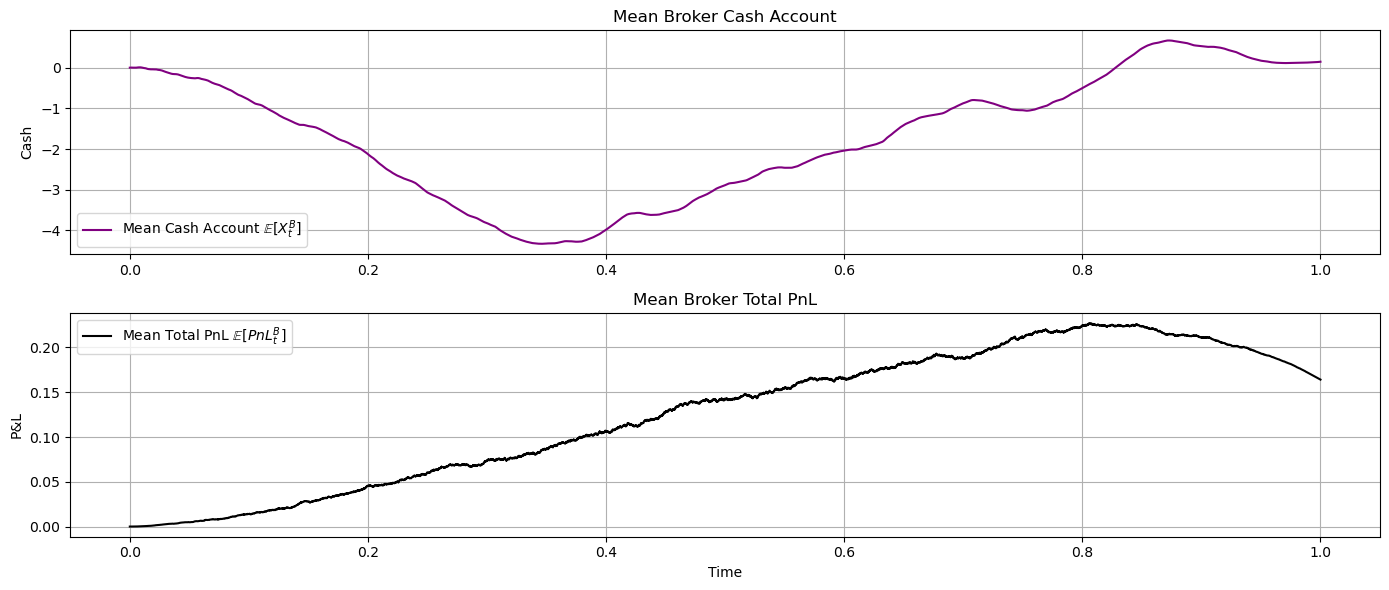

In [348]:
plt.figure(figsize = (14, 6))

# Mean Cash Account of Broker
plt.subplot(2, 1, 1)
plt.plot(time_grid, mean_X_B, label='Mean Cash Account $\\mathbb{E}[X^B_t]$', color='purple')
plt.ylabel('Cash')
plt.title('Mean Broker Cash Account')
plt.grid(True)
plt.legend()

# Mean Total PnL of Broker
plt.subplot(2, 1, 2)
plt.plot(time_grid, mean_PnL_B, label='Mean Total PnL $\\mathbb{E}[PnL^B_t]$', color='black')
plt.xlabel('Time')
plt.ylabel('P&L')
plt.title('Mean Broker Total PnL')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [351]:
mean_PnL_B[-1]

0.16411306092499717

**Value Function Analysis**

In [354]:
def compute_broker_value_function():
    M, N = alpha.shape
    q_val = np.zeros((M, N))

    for j in range(N):
        t = time_grid[j]

        # Interpolação dos coeficientes q_i(t)
        q0_t  = np.interp(t, time_grid, q0_sol)
        q2_t  = np.interp(t, time_grid, q2_sol)
        q4_t  = np.interp(t, time_grid, q4_sol)
        q6_t  = np.interp(t, time_grid, q6_sol)
        q7_t  = np.interp(t, time_grid, q7_sol)
        q8_t  = np.interp(t, time_grid, q8_sol)
        q9_t  = np.interp(t, time_grid, q9_sol)
        q10_t = np.interp(t, time_grid, q10_sol)
        q11_t = np.interp(t, time_grid, q11_sol)
        q12_t = np.interp(t, time_grid, q12_sol)
        q13_t = np.interp(t, time_grid, q13_sol)
        q14_t = np.interp(t, time_grid, q14_sol)

        # Avaliação de q(t, ...)
        q_val[:, j] = (
            q0_t
            + q2_t  * alpha[:, j]**2
            + q4_t  * Q_B[:, j]**2
            + q6_t  * Q_I[:, j]**2
            + q7_t  * nu_U[:, j]
            + q8_t  * nu_U[:, j]**2
            + q9_t  * alpha[:, j] * Q_B[:, j]
            + q10_t * alpha[:, j] * Q_I[:, j]
            + q11_t * alpha[:, j] * nu_U[:, j]
            + q12_t * Q_B[:, j] * Q_I[:, j]
            + q13_t * Q_B[:, j] * nu_U[:, j]
            + q14_t * Q_I[:, j] * nu_U[:, j]
        )

    Omega = X_B + Q_B * S + q_val
    return Omega

In [356]:
V_brk = compute_broker_value_function()

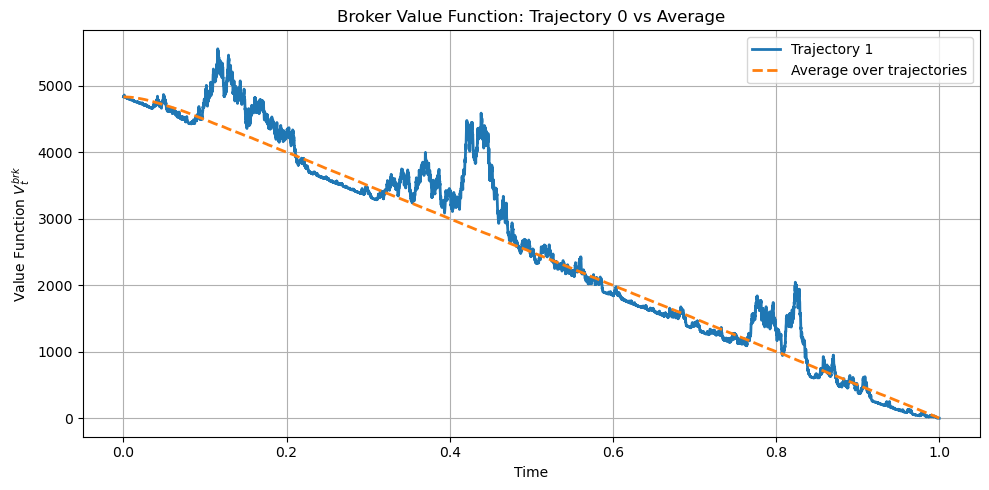

In [357]:
# Plot the broker value function for trajectory 0 and the average across all trajectories
plt.figure(figsize=(10, 5))

# Plot trajectory 0
plt.plot(time_grid, V_brk[0, :], label = "Trajectory 1", linewidth=2)

# Plot the average across all M trajectories
plt.plot(time_grid, V_brk.mean(axis = 0), label = "Average over trajectories", linestyle = '--', linewidth=2)

# Axis labels and title
plt.xlabel("Time")
plt.ylabel("Value Function $V^{brk}_t$")
plt.title("Broker Value Function: Trajectory 0 vs Average")

# Legend and grid
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [362]:
V_brk.mean(axis = 0)[-1]

0.1625849902413073

In [2119]:
from scipy.integrate import cumtrapz

integrand = (
    kappa_U
    - 0.5 * varphiB * sigma_alpha**2 * q11_sol**2
    - q13_sol
    + (q13_sol**2) / (4 * kB)
)

kernel = np.exp(-2 * kappa_U * (T - time_grid))
q8_sol_check = cumtrapz(integrand * kernel, time_grid, initial=0)


/var/folders/x1/p2tkv_rs1ds1nx4vjpt3wh4w0000gn/T/ipykernel_23723/1989854324.py:11: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  q8_sol_check = cumtrapz(integrand * kernel, time_grid, initial=0)


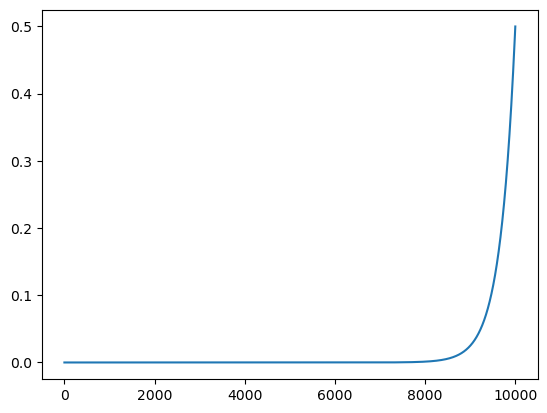

In [2121]:
plt.plot(q8_sol_check)

In [2123]:

import numpy as np

# Pré-cálculo do integrando f(u)
integrand = (
    kappa_U
    - 0.5 * varphiB * sigma_alpha**2 * q11_sol**2
    - q13_sol
    + (q13_sol**2) / (4 * kB)
)

# Inicializa vetor resultado
q8_sol_check_2 = np.zeros_like(time_grid)

# Loop sobre cada t = time_grid[i]
for i, t in enumerate(time_grid):
    u = time_grid[i:]          # pontos futuros: u ∈ [t, T]
    f = integrand[i:]          # integrando correspondente
    kernel = np.exp(-2 * kappa_U * (u - t))  # núcleo exponencial
    q8_sol_check_2[i] = np.trapz(f * kernel, u)  # integração


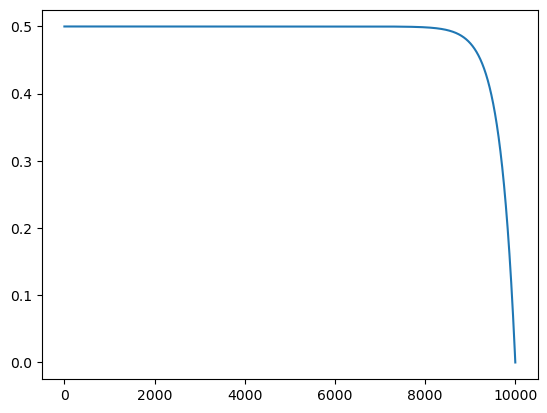

In [2124]:
plt.plot(q8_sol_check_2)